In [1]:
!nvidia-smi

Wed Apr  3 12:01:51 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.29.06              Driver Version: 545.29.06    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100 80GB PCIe          Off | 00000000:22:00.0 Off |                    0 |
| N/A   34C    P0              80W / 300W |  11635MiB / 81920MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [2]:
import sys, os
from lora import LoRA, image_grid
from data_loader import get_data_loader
import matplotlib.pyplot as plt

import torch
print(torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print('Device:', device)
print('Current cuda device:', torch.cuda.current_device())
print('Count of using GPUs:', torch.cuda.device_count())

/root/.pyenv/versions/3.10.13/lib/python3.10/site-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


True
Device: cuda
Current cuda device: 0
Count of using GPUs: 1


## Set LoRA pipe
---

In [4]:
model = LoRA("dreamlike-art/dreamlike-photoreal-2.0")

- base_model_path: dreamlike-art/dreamlike-photoreal-2.0
- device: cuda
- seed: 1


In [5]:
model.set_pipe()

/root/.pyenv/versions/3.10.13/lib/python3.10/site-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

/root/.pyenv/versions/3.10.13/lib/python3.10/site-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


## DataLoader
---

In [6]:
train_dataloader = get_data_loader(dataset_folder =  '/root/box/datasets/bmw/all',
                                  tokenizer = model.pipe.tokenizer, # we get tokenizer by pipe
                                  train_batch_size = 1,
                                  center_crop = True,
                                  random_flip = True,
                                  )

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 3, 512, 512]) torch.Size([1, 77])


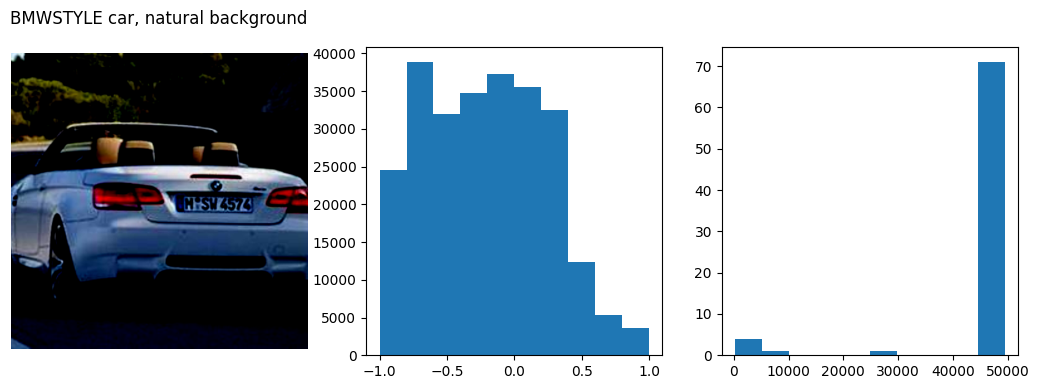

In [7]:
for step, batch in enumerate(train_dataloader):
    img = batch["pixel_values"]
    token = batch["tokens"]
    caption = batch["captions"]

    print(img.shape, token.shape)

    for i in range(img.shape[0]):
        plt.figure(figsize=(13,4))
        plt.subplot(131)
        plt.title(caption[i][0])
        plt.imshow(img[i].permute(1,2,0))
        plt.axis('off')

        plt.subplot(132)
        plt.hist(img[i,0,10:].flatten())
        plt.subplot(133)
        plt.hist(token[i])
        plt.show()

    break


## Train
---

In [7]:
#1 epoch == 75 step
#13 epoch ~= 1000 step

In [8]:
model.train(
      train_dataloader,
      output_dir = 'results/230402-05-bmw-dreamlike',
      # data
      img_w = 512,
      img_h = 512,
      # train
      mixed_precision = "fp16", #["no", "bf16"] Whether to use mixed precision. Choose between fp16 and bf16 (bfloat16). Bf16 requires PyTorch >=
      num_train_epochs = 20, 
      gradient_accumulation_steps=16, # Number of updates steps to accumulate before performing a backward/update pass.
      learning_rate = 1e-4, 
      max_train_steps = None,
      checkpointing_steps = 20,
      lr_scheduler = "cosine", # ["linear", "cosine", "cosine_with_restarts", "polynomial","constant", "constant_with_warmup"]'
      lr_warmup_steps = 20,
      # infer
      infer_prompts=[
                    "BMWSTYLE photo of bmw green car design, front view",
                    "BMWSTYLE skatch of bmw red car design, side view.",
                    "BMWSTYLE photo of bmw pink car design, front view, Make sure the BMWLOGO is clearly visible on the front of the car.",
                    "BMWLOGO"], 
                     
      n_infer_steps=20,
      n_infer_imgs=2, 
      )


        ***** Running training *****
          Project directory = results/230402-05-bmw-dreamlike
          Num examples = 773
          Num Epochs = 20
          Instantaneous batch size per device = 1
          Total train batch size (w. parallel, distributed & accumulation) = 16
          Gradient Accumulation steps = 16
          Total optimization steps = 980
          Checkpointing steps = 20
        


Steps:   0%|                                                  | 0/980 [00:00<?, ?it/s]/root/.pyenv/versions/3.10.13/lib/python3.10/site-packages/diffusers/models/attention_processor.py:1871: FutureWarning: `LoRAAttnProcessor` is deprecated and will be removed in version 0.26.0. Make sure use AttnProcessor instead by settingLoRA layers to `self.{to_q,to_k,to_v,to_out[0]}.lora_layer` respectively. This will be done automatically when using `LoraLoaderMixin.load_lora_weights`
  deprecate(
Steps:   2%|▏           | 20/980 [00:48<37:37,  2.35s/it, lr=9.5e-5, step_loss=0.0114]

Saved state to results/230402-05-bmw-dreamlike/checkpoint-000020
Running validation with prompt: ['BMWSTYLE photo of bmw green car design, front view', 'BMWSTYLE skatch of bmw red car design, side view.', 'BMWSTYLE photo of bmw pink car design, front view, Make sure the BMWLOGO is clearly visible on the front of the car.', 'BMWLOGO']


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

Steps:   4%|▍          | 40/980 [01:41<35:44,  2.28s/it, lr=9.99e-5, step_loss=0.0375]

Saved state to results/230402-05-bmw-dreamlike/checkpoint-000040
Running validation with prompt: ['BMWSTYLE photo of bmw green car design, front view', 'BMWSTYLE skatch of bmw red car design, side view.', 'BMWSTYLE photo of bmw pink car design, front view, Make sure the BMWLOGO is clearly visible on the front of the car.', 'BMWLOGO']


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

Steps:   6%|▋          | 60/980 [02:32<34:48,  2.27s/it, lr=9.96e-5, step_loss=0.0803]

Saved state to results/230402-05-bmw-dreamlike/checkpoint-000060
Running validation with prompt: ['BMWSTYLE photo of bmw green car design, front view', 'BMWSTYLE skatch of bmw red car design, side view.', 'BMWSTYLE photo of bmw pink car design, front view, Make sure the BMWLOGO is clearly visible on the front of the car.', 'BMWLOGO']


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

Steps:   8%|▉          | 80/980 [03:24<33:38,  2.24s/it, lr=9.91e-5, step_loss=0.0365]

Saved state to results/230402-05-bmw-dreamlike/checkpoint-000080
Running validation with prompt: ['BMWSTYLE photo of bmw green car design, front view', 'BMWSTYLE skatch of bmw red car design, side view.', 'BMWSTYLE photo of bmw pink car design, front view, Make sure the BMWLOGO is clearly visible on the front of the car.', 'BMWLOGO']


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

Steps:  10%|█         | 100/980 [04:16<31:50,  2.17s/it, lr=9.83e-5, step_loss=0.0579]

Saved state to results/230402-05-bmw-dreamlike/checkpoint-000100
Running validation with prompt: ['BMWSTYLE photo of bmw green car design, front view', 'BMWSTYLE skatch of bmw red car design, side view.', 'BMWSTYLE photo of bmw pink car design, front view, Make sure the BMWLOGO is clearly visible on the front of the car.', 'BMWLOGO']


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

Steps:  12%|█▏        | 120/980 [05:09<33:12,  2.32s/it, lr=9.74e-5, step_loss=0.0405]

Saved state to results/230402-05-bmw-dreamlike/checkpoint-000120
Running validation with prompt: ['BMWSTYLE photo of bmw green car design, front view', 'BMWSTYLE skatch of bmw red car design, side view.', 'BMWSTYLE photo of bmw pink car design, front view, Make sure the BMWLOGO is clearly visible on the front of the car.', 'BMWLOGO']


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

Steps:  14%|█▌         | 140/980 [06:02<31:33,  2.25s/it, lr=9.63e-5, step_loss=0.044]

Saved state to results/230402-05-bmw-dreamlike/checkpoint-000140
Running validation with prompt: ['BMWSTYLE photo of bmw green car design, front view', 'BMWSTYLE skatch of bmw red car design, side view.', 'BMWSTYLE photo of bmw pink car design, front view, Make sure the BMWLOGO is clearly visible on the front of the car.', 'BMWLOGO']


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

Steps:  16%|█▋        | 160/980 [06:54<32:47,  2.40s/it, lr=9.49e-5, step_loss=0.0711]

Saved state to results/230402-05-bmw-dreamlike/checkpoint-000160
Running validation with prompt: ['BMWSTYLE photo of bmw green car design, front view', 'BMWSTYLE skatch of bmw red car design, side view.', 'BMWSTYLE photo of bmw pink car design, front view, Make sure the BMWLOGO is clearly visible on the front of the car.', 'BMWLOGO']


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

Steps:  18%|█▊        | 180/980 [07:48<31:21,  2.35s/it, lr=9.34e-5, step_loss=0.0265]

Saved state to results/230402-05-bmw-dreamlike/checkpoint-000180
Running validation with prompt: ['BMWSTYLE photo of bmw green car design, front view', 'BMWSTYLE skatch of bmw red car design, side view.', 'BMWSTYLE photo of bmw pink car design, front view, Make sure the BMWLOGO is clearly visible on the front of the car.', 'BMWLOGO']


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

Steps:  20%|██        | 200/980 [08:39<28:41,  2.21s/it, lr=9.17e-5, step_loss=0.0812]

Saved state to results/230402-05-bmw-dreamlike/checkpoint-000200
Running validation with prompt: ['BMWSTYLE photo of bmw green car design, front view', 'BMWSTYLE skatch of bmw red car design, side view.', 'BMWSTYLE photo of bmw pink car design, front view, Make sure the BMWLOGO is clearly visible on the front of the car.', 'BMWLOGO']


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

Steps:  22%|██▍        | 220/980 [09:33<28:15,  2.23s/it, lr=8.98e-5, step_loss=0.039]

Saved state to results/230402-05-bmw-dreamlike/checkpoint-000220
Running validation with prompt: ['BMWSTYLE photo of bmw green car design, front view', 'BMWSTYLE skatch of bmw red car design, side view.', 'BMWSTYLE photo of bmw pink car design, front view, Make sure the BMWLOGO is clearly visible on the front of the car.', 'BMWLOGO']


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

Steps:  24%|██▍       | 240/980 [10:25<29:00,  2.35s/it, lr=8.77e-5, step_loss=0.0422]

Saved state to results/230402-05-bmw-dreamlike/checkpoint-000240
Running validation with prompt: ['BMWSTYLE photo of bmw green car design, front view', 'BMWSTYLE skatch of bmw red car design, side view.', 'BMWSTYLE photo of bmw pink car design, front view, Make sure the BMWLOGO is clearly visible on the front of the car.', 'BMWLOGO']


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

Steps:  27%|██▉        | 260/980 [11:19<29:21,  2.45s/it, lr=8.55e-5, step_loss=0.108]

Saved state to results/230402-05-bmw-dreamlike/checkpoint-000260
Running validation with prompt: ['BMWSTYLE photo of bmw green car design, front view', 'BMWSTYLE skatch of bmw red car design, side view.', 'BMWSTYLE photo of bmw pink car design, front view, Make sure the BMWLOGO is clearly visible on the front of the car.', 'BMWLOGO']


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

Steps:  29%|██▊       | 280/980 [12:14<27:54,  2.39s/it, lr=8.31e-5, step_loss=0.0387]

Saved state to results/230402-05-bmw-dreamlike/checkpoint-000280
Running validation with prompt: ['BMWSTYLE photo of bmw green car design, front view', 'BMWSTYLE skatch of bmw red car design, side view.', 'BMWSTYLE photo of bmw pink car design, front view, Make sure the BMWLOGO is clearly visible on the front of the car.', 'BMWLOGO']


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

Steps:  31%|███▎       | 300/980 [13:06<24:45,  2.18s/it, lr=8.06e-5, step_loss=0.073]

Saved state to results/230402-05-bmw-dreamlike/checkpoint-000300
Running validation with prompt: ['BMWSTYLE photo of bmw green car design, front view', 'BMWSTYLE skatch of bmw red car design, side view.', 'BMWSTYLE photo of bmw pink car design, front view, Make sure the BMWLOGO is clearly visible on the front of the car.', 'BMWLOGO']


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

Steps:  33%|███▎      | 320/980 [13:58<24:26,  2.22s/it, lr=7.79e-5, step_loss=0.0339]

Saved state to results/230402-05-bmw-dreamlike/checkpoint-000320
Running validation with prompt: ['BMWSTYLE photo of bmw green car design, front view', 'BMWSTYLE skatch of bmw red car design, side view.', 'BMWSTYLE photo of bmw pink car design, front view, Make sure the BMWLOGO is clearly visible on the front of the car.', 'BMWLOGO']


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

Steps:  35%|███▍      | 340/980 [14:51<23:44,  2.23s/it, lr=7.51e-5, step_loss=0.0203]

Saved state to results/230402-05-bmw-dreamlike/checkpoint-000340
Running validation with prompt: ['BMWSTYLE photo of bmw green car design, front view', 'BMWSTYLE skatch of bmw red car design, side view.', 'BMWSTYLE photo of bmw pink car design, front view, Make sure the BMWLOGO is clearly visible on the front of the car.', 'BMWLOGO']


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

Steps:  37%|███▋      | 360/980 [15:42<24:24,  2.36s/it, lr=7.23e-5, step_loss=0.0961]

Saved state to results/230402-05-bmw-dreamlike/checkpoint-000360
Running validation with prompt: ['BMWSTYLE photo of bmw green car design, front view', 'BMWSTYLE skatch of bmw red car design, side view.', 'BMWSTYLE photo of bmw pink car design, front view, Make sure the BMWLOGO is clearly visible on the front of the car.', 'BMWLOGO']


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

Steps:  39%|███▉      | 380/980 [16:34<22:29,  2.25s/it, lr=6.93e-5, step_loss=0.0244]

Saved state to results/230402-05-bmw-dreamlike/checkpoint-000380
Running validation with prompt: ['BMWSTYLE photo of bmw green car design, front view', 'BMWSTYLE skatch of bmw red car design, side view.', 'BMWSTYLE photo of bmw pink car design, front view, Make sure the BMWLOGO is clearly visible on the front of the car.', 'BMWLOGO']


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

Steps:  41%|████      | 400/980 [17:25<22:33,  2.33s/it, lr=6.62e-5, step_loss=0.0827]

Saved state to results/230402-05-bmw-dreamlike/checkpoint-000400
Running validation with prompt: ['BMWSTYLE photo of bmw green car design, front view', 'BMWSTYLE skatch of bmw red car design, side view.', 'BMWSTYLE photo of bmw pink car design, front view, Make sure the BMWLOGO is clearly visible on the front of the car.', 'BMWLOGO']


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

Steps:  43%|████▎     | 420/980 [18:18<22:24,  2.40s/it, lr=6.31e-5, step_loss=0.0421]

Saved state to results/230402-05-bmw-dreamlike/checkpoint-000420
Running validation with prompt: ['BMWSTYLE photo of bmw green car design, front view', 'BMWSTYLE skatch of bmw red car design, side view.', 'BMWSTYLE photo of bmw pink car design, front view, Make sure the BMWLOGO is clearly visible on the front of the car.', 'BMWLOGO']


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

Steps:  45%|████▍     | 440/980 [19:11<20:03,  2.23s/it, lr=5.99e-5, step_loss=0.0381]

Saved state to results/230402-05-bmw-dreamlike/checkpoint-000440
Running validation with prompt: ['BMWSTYLE photo of bmw green car design, front view', 'BMWSTYLE skatch of bmw red car design, side view.', 'BMWSTYLE photo of bmw pink car design, front view, Make sure the BMWLOGO is clearly visible on the front of the car.', 'BMWLOGO']


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

Steps:  47%|████▋     | 460/980 [20:04<20:25,  2.36s/it, lr=5.67e-5, step_loss=0.0754]

Saved state to results/230402-05-bmw-dreamlike/checkpoint-000460
Running validation with prompt: ['BMWSTYLE photo of bmw green car design, front view', 'BMWSTYLE skatch of bmw red car design, side view.', 'BMWSTYLE photo of bmw pink car design, front view, Make sure the BMWLOGO is clearly visible on the front of the car.', 'BMWLOGO']


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

Steps:  49%|████▉     | 480/980 [20:57<18:50,  2.26s/it, lr=5.34e-5, step_loss=0.0419]

Saved state to results/230402-05-bmw-dreamlike/checkpoint-000480
Running validation with prompt: ['BMWSTYLE photo of bmw green car design, front view', 'BMWSTYLE skatch of bmw red car design, side view.', 'BMWSTYLE photo of bmw pink car design, front view, Make sure the BMWLOGO is clearly visible on the front of the car.', 'BMWLOGO']


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

Steps:  51%|█████     | 500/980 [21:49<18:37,  2.33s/it, lr=5.02e-5, step_loss=0.0774]

Saved state to results/230402-05-bmw-dreamlike/checkpoint-000500
Running validation with prompt: ['BMWSTYLE photo of bmw green car design, front view', 'BMWSTYLE skatch of bmw red car design, side view.', 'BMWSTYLE photo of bmw pink car design, front view, Make sure the BMWLOGO is clearly visible on the front of the car.', 'BMWLOGO']


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

Steps:  53%|█████▎    | 520/980 [22:44<18:36,  2.43s/it, lr=4.69e-5, step_loss=0.0369]

Saved state to results/230402-05-bmw-dreamlike/checkpoint-000520
Running validation with prompt: ['BMWSTYLE photo of bmw green car design, front view', 'BMWSTYLE skatch of bmw red car design, side view.', 'BMWSTYLE photo of bmw pink car design, front view, Make sure the BMWLOGO is clearly visible on the front of the car.', 'BMWLOGO']


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

Steps:  55%|█████▌    | 540/980 [23:36<14:34,  1.99s/it, lr=4.36e-5, step_loss=0.0874]

Saved state to results/230402-05-bmw-dreamlike/checkpoint-000540
Running validation with prompt: ['BMWSTYLE photo of bmw green car design, front view', 'BMWSTYLE skatch of bmw red car design, side view.', 'BMWSTYLE photo of bmw pink car design, front view, Make sure the BMWLOGO is clearly visible on the front of the car.', 'BMWLOGO']


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

Steps:  57%|█████▋    | 560/980 [24:27<15:25,  2.20s/it, lr=4.04e-5, step_loss=0.0377]

Saved state to results/230402-05-bmw-dreamlike/checkpoint-000560
Running validation with prompt: ['BMWSTYLE photo of bmw green car design, front view', 'BMWSTYLE skatch of bmw red car design, side view.', 'BMWSTYLE photo of bmw pink car design, front view, Make sure the BMWLOGO is clearly visible on the front of the car.', 'BMWLOGO']


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

Steps:  59%|█████▉    | 580/980 [25:19<15:01,  2.25s/it, lr=3.72e-5, step_loss=0.0349]

Saved state to results/230402-05-bmw-dreamlike/checkpoint-000580
Running validation with prompt: ['BMWSTYLE photo of bmw green car design, front view', 'BMWSTYLE skatch of bmw red car design, side view.', 'BMWSTYLE photo of bmw pink car design, front view, Make sure the BMWLOGO is clearly visible on the front of the car.', 'BMWLOGO']


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

Steps:  61%|██████    | 600/980 [26:10<13:57,  2.20s/it, lr=3.41e-5, step_loss=0.0692]

Saved state to results/230402-05-bmw-dreamlike/checkpoint-000600
Running validation with prompt: ['BMWSTYLE photo of bmw green car design, front view', 'BMWSTYLE skatch of bmw red car design, side view.', 'BMWSTYLE photo of bmw pink car design, front view, Make sure the BMWLOGO is clearly visible on the front of the car.', 'BMWLOGO']


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

Steps:  63%|██████▉    | 620/980 [27:02<13:24,  2.24s/it, lr=3.1e-5, step_loss=0.0285]

Saved state to results/230402-05-bmw-dreamlike/checkpoint-000620
Running validation with prompt: ['BMWSTYLE photo of bmw green car design, front view', 'BMWSTYLE skatch of bmw red car design, side view.', 'BMWSTYLE photo of bmw pink car design, front view, Make sure the BMWLOGO is clearly visible on the front of the car.', 'BMWLOGO']


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

Steps:  65%|███████▏   | 640/980 [27:54<12:19,  2.17s/it, lr=2.8e-5, step_loss=0.0912]

Saved state to results/230402-05-bmw-dreamlike/checkpoint-000640
Running validation with prompt: ['BMWSTYLE photo of bmw green car design, front view', 'BMWSTYLE skatch of bmw red car design, side view.', 'BMWSTYLE photo of bmw pink car design, front view, Make sure the BMWLOGO is clearly visible on the front of the car.', 'BMWLOGO']


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

Steps:  67%|██████▋   | 660/980 [28:46<11:46,  2.21s/it, lr=2.51e-5, step_loss=0.0326]

Saved state to results/230402-05-bmw-dreamlike/checkpoint-000660
Running validation with prompt: ['BMWSTYLE photo of bmw green car design, front view', 'BMWSTYLE skatch of bmw red car design, side view.', 'BMWSTYLE photo of bmw pink car design, front view, Make sure the BMWLOGO is clearly visible on the front of the car.', 'BMWLOGO']


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

Steps:  69%|███████▋   | 680/980 [29:38<11:10,  2.23s/it, lr=2.24e-5, step_loss=0.035]

Saved state to results/230402-05-bmw-dreamlike/checkpoint-000680
Running validation with prompt: ['BMWSTYLE photo of bmw green car design, front view', 'BMWSTYLE skatch of bmw red car design, side view.', 'BMWSTYLE photo of bmw pink car design, front view, Make sure the BMWLOGO is clearly visible on the front of the car.', 'BMWLOGO']


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

Steps:  71%|███████▏  | 700/980 [30:30<10:36,  2.27s/it, lr=1.97e-5, step_loss=0.0834]

Saved state to results/230402-05-bmw-dreamlike/checkpoint-000700
Running validation with prompt: ['BMWSTYLE photo of bmw green car design, front view', 'BMWSTYLE skatch of bmw red car design, side view.', 'BMWSTYLE photo of bmw pink car design, front view, Make sure the BMWLOGO is clearly visible on the front of the car.', 'BMWLOGO']


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

Steps:  73%|███████▎  | 720/980 [31:24<10:16,  2.37s/it, lr=1.72e-5, step_loss=0.0267]

Saved state to results/230402-05-bmw-dreamlike/checkpoint-000720
Running validation with prompt: ['BMWSTYLE photo of bmw green car design, front view', 'BMWSTYLE skatch of bmw red car design, side view.', 'BMWSTYLE photo of bmw pink car design, front view, Make sure the BMWLOGO is clearly visible on the front of the car.', 'BMWLOGO']


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

Steps:  76%|███████▌  | 740/980 [32:17<09:12,  2.30s/it, lr=1.48e-5, step_loss=0.0453]

Saved state to results/230402-05-bmw-dreamlike/checkpoint-000740
Running validation with prompt: ['BMWSTYLE photo of bmw green car design, front view', 'BMWSTYLE skatch of bmw red car design, side view.', 'BMWSTYLE photo of bmw pink car design, front view, Make sure the BMWLOGO is clearly visible on the front of the car.', 'BMWLOGO']


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

Steps:  78%|███████▊  | 760/980 [33:11<08:46,  2.39s/it, lr=1.25e-5, step_loss=0.0492]

Saved state to results/230402-05-bmw-dreamlike/checkpoint-000760
Running validation with prompt: ['BMWSTYLE photo of bmw green car design, front view', 'BMWSTYLE skatch of bmw red car design, side view.', 'BMWSTYLE photo of bmw pink car design, front view, Make sure the BMWLOGO is clearly visible on the front of the car.', 'BMWLOGO']


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

Steps:  80%|███████▉  | 780/980 [34:05<07:48,  2.34s/it, lr=1.04e-5, step_loss=0.0313]

Saved state to results/230402-05-bmw-dreamlike/checkpoint-000780
Running validation with prompt: ['BMWSTYLE photo of bmw green car design, front view', 'BMWSTYLE skatch of bmw red car design, side view.', 'BMWSTYLE photo of bmw pink car design, front view, Make sure the BMWLOGO is clearly visible on the front of the car.', 'BMWLOGO']


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

Steps:  82%|████████▏ | 800/980 [34:56<06:44,  2.24s/it, lr=8.52e-6, step_loss=0.0843]

Saved state to results/230402-05-bmw-dreamlike/checkpoint-000800
Running validation with prompt: ['BMWSTYLE photo of bmw green car design, front view', 'BMWSTYLE skatch of bmw red car design, side view.', 'BMWSTYLE photo of bmw pink car design, front view, Make sure the BMWLOGO is clearly visible on the front of the car.', 'BMWLOGO']


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

Steps:  84%|████████▎ | 820/980 [35:48<06:11,  2.32s/it, lr=6.78e-6, step_loss=0.0386]

Saved state to results/230402-05-bmw-dreamlike/checkpoint-000820
Running validation with prompt: ['BMWSTYLE photo of bmw green car design, front view', 'BMWSTYLE skatch of bmw red car design, side view.', 'BMWSTYLE photo of bmw pink car design, front view, Make sure the BMWLOGO is clearly visible on the front of the car.', 'BMWLOGO']


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

Steps:  86%|████████▌ | 840/980 [36:40<05:06,  2.19s/it, lr=5.23e-6, step_loss=0.0868]

Saved state to results/230402-05-bmw-dreamlike/checkpoint-000840
Running validation with prompt: ['BMWSTYLE photo of bmw green car design, front view', 'BMWSTYLE skatch of bmw red car design, side view.', 'BMWSTYLE photo of bmw pink car design, front view, Make sure the BMWLOGO is clearly visible on the front of the car.', 'BMWLOGO']


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

Steps:  88%|████████▊ | 860/980 [37:31<04:35,  2.30s/it, lr=3.87e-6, step_loss=0.0467]

Saved state to results/230402-05-bmw-dreamlike/checkpoint-000860
Running validation with prompt: ['BMWSTYLE photo of bmw green car design, front view', 'BMWSTYLE skatch of bmw red car design, side view.', 'BMWSTYLE photo of bmw pink car design, front view, Make sure the BMWLOGO is clearly visible on the front of the car.', 'BMWLOGO']


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

Steps:  90%|████████▉ | 880/980 [38:27<04:02,  2.42s/it, lr=2.71e-6, step_loss=0.0374]

Saved state to results/230402-05-bmw-dreamlike/checkpoint-000880
Running validation with prompt: ['BMWSTYLE photo of bmw green car design, front view', 'BMWSTYLE skatch of bmw red car design, side view.', 'BMWSTYLE photo of bmw pink car design, front view, Make sure the BMWLOGO is clearly visible on the front of the car.', 'BMWLOGO']


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

Steps:  92%|█████████▏| 900/980 [39:19<03:05,  2.32s/it, lr=1.75e-6, step_loss=0.0664]

Saved state to results/230402-05-bmw-dreamlike/checkpoint-000900
Running validation with prompt: ['BMWSTYLE photo of bmw green car design, front view', 'BMWSTYLE skatch of bmw red car design, side view.', 'BMWSTYLE photo of bmw pink car design, front view, Make sure the BMWLOGO is clearly visible on the front of the car.', 'BMWLOGO']


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

Steps:  94%|██████████▎| 920/980 [40:13<02:19,  2.33s/it, lr=9.93e-7, step_loss=0.033]

Saved state to results/230402-05-bmw-dreamlike/checkpoint-000920
Running validation with prompt: ['BMWSTYLE photo of bmw green car design, front view', 'BMWSTYLE skatch of bmw red car design, side view.', 'BMWSTYLE photo of bmw pink car design, front view, Make sure the BMWLOGO is clearly visible on the front of the car.', 'BMWLOGO']


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

Steps:  96%|█████████▌| 940/980 [41:05<01:37,  2.43s/it, lr=4.49e-7, step_loss=0.0486]

Saved state to results/230402-05-bmw-dreamlike/checkpoint-000940
Running validation with prompt: ['BMWSTYLE photo of bmw green car design, front view', 'BMWSTYLE skatch of bmw red car design, side view.', 'BMWSTYLE photo of bmw pink car design, front view, Make sure the BMWLOGO is clearly visible on the front of the car.', 'BMWLOGO']


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

Steps:  98%|█████████▊| 960/980 [41:59<00:46,  2.34s/it, lr=1.18e-7, step_loss=0.0429]

Saved state to results/230402-05-bmw-dreamlike/checkpoint-000960
Running validation with prompt: ['BMWSTYLE photo of bmw green car design, front view', 'BMWSTYLE skatch of bmw red car design, side view.', 'BMWSTYLE photo of bmw pink car design, front view, Make sure the BMWLOGO is clearly visible on the front of the car.', 'BMWLOGO']


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

Steps: 100%|█████████| 980/980 [42:51<00:00,  1.86s/it, lr=2.68e-10, step_loss=0.0548]

Saved state to results/230402-05-bmw-dreamlike/checkpoint-000980
Running validation with prompt: ['BMWSTYLE photo of bmw green car design, front view', 'BMWSTYLE skatch of bmw red car design, side view.', 'BMWSTYLE photo of bmw pink car design, front view, Make sure the BMWLOGO is clearly visible on the front of the car.', 'BMWLOGO']


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

Steps: 100%|████████████████| 980/980 [42:58<00:00,  2.63s/it, lr=0, step_loss=0.0872]


## Inference with Pretrained lora weights
---

In [1]:
import sys, os
sys.path.append('./scripts/')
from lora import LoRA, image_grid
import matplotlib.pyplot as plt

import torch
print(torch.cuda.is_available())

/root/.pyenv/versions/3.10.13/lib/python3.10/site-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


True


### Base model : SD 1.5

In [22]:
model = LoRA()
model.set_pipe()

- base_model_path: runwayml/stable-diffusion-v1-5
- device: cuda
- seed: 1


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


#### SD 1.5 only

In [55]:
txt = f'Photorealistic camera shot, with highly detailed body. Ultra-detailed 8K resolution. Crisp quality.'

In [23]:
for i in range(4):
    model.seed=i+5
    print(model.seed)
    imgs = model.infer( prompts=[
                    "bmw style green car, front view. ", 
                    "bmw style red car, side view. ",
                    "bmw style black diagonal view. ",
                    "bmw style white car ",
    ], 
                        n = 1)
    grid = image_grid(imgs, 1, len(imgs))
    grid.save(f'sd15_{i}.png')

5


  0%|          | 0/20 [00:00<?, ?it/s]

6


  0%|          | 0/20 [00:00<?, ?it/s]

7


  0%|          | 0/20 [00:00<?, ?it/s]

8


  0%|          | 0/20 [00:00<?, ?it/s]

#### SD 1.5 + Lora weights

* Get checkpoint weights
    * After train, checkpoint were saved.
    * Change weights name "pytorch_model.bin" to "pytorch_lora_weights.bin" 

In [24]:
model.pipe.unet.load_attn_procs('results/230402-04-bmw-sd15')

In [25]:
for i in range(4):
    model.seed=i+5
    print(model.seed)
    imgs = model.infer( prompts=[
                    "BMWSTYLE green car, front view.", 
                    "BMWSTYLE red car, side view.",
                    "BMWSTYLE black diagonal view.",
                    "BMWSTYLE white car ",

    ], 
                        n = 1)
    grid = image_grid(imgs, 1, len(imgs))
    grid.save(f'sd15_lora_{i}.png')

5


  0%|          | 0/20 [00:00<?, ?it/s]

6


  0%|          | 0/20 [00:00<?, ?it/s]

7


  0%|          | 0/20 [00:00<?, ?it/s]

8


  0%|          | 0/20 [00:00<?, ?it/s]

In [5]:
model.pipe.save_pretrained('pipe-dreamlike')

### Base model : DreamLike

In [26]:
model = LoRA("dreamlike-art/dreamlike-photoreal-2.0")
model.set_pipe()

- base_model_path: dreamlike-art/dreamlike-photoreal-2.0
- device: cuda
- seed: 1


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

#### Dreamlike only

In [27]:
txt = f'Photorealistic camera shot, with highly detailed body. Ultra-detailed 8K resolution. Crisp quality.'
for i in range(4):
    model.seed=i+5
    print(model.seed)
    imgs = model.infer( prompts=[
                    "bmw style green car, front view. ", 
                    "bmw style red car, side view. ",
                    "bmw style black, diagonal view. ",
                    "bmw style white car ",
    ], 
                        n = 1)
    grid = image_grid(imgs, 1, len(imgs))
    grid.save(f'dreamlike_{i}.png')

5


  0%|          | 0/20 [00:00<?, ?it/s]

6


  0%|          | 0/20 [00:00<?, ?it/s]

7


  0%|          | 0/20 [00:00<?, ?it/s]

8


  0%|          | 0/20 [00:00<?, ?it/s]

#### Dreamlike + Lora

* Get checkpoint weights
    * After train, checkpoint were saved.
    * Change weights name "pytorch_model.bin" to "pytorch_lora_weights.bin" 

In [19]:
model.pipe.unet.load_attn_procs('results/230402-05-bmw-dreamlike/checkpoint-000980/')

In [21]:
for i in range(4):
    model.seed=i+5
    print(model.seed)
    imgs = model.infer( prompts=[
                    "BMWSTYLE green car, front view. ", 
                    "BMWSTYLE red car, side view. ",
                    "BMWSTYLE black, diagonal view. ",
                    "BMWSTYLE white car ",

    ], 
                        n = 1)
    grid = image_grid(imgs, 1, len(imgs))
    grid.save(f'dreamlike_lora_{i}.png')

5


  0%|          | 0/20 [00:00<?, ?it/s]

6


  0%|          | 0/20 [00:00<?, ?it/s]

7


  0%|          | 0/20 [00:00<?, ?it/s]

8


  0%|          | 0/20 [00:00<?, ?it/s]

In [10]:
model.pipe.save_pretrained('pipe-lora-dreamlike')